<a href="https://colab.research.google.com/github/kutyadog/ai_notebooks/blob/main/Kaggle_skin_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

My attempt at Kaggle competition for detecting skin cancer.
I had mixed results.
August 2024


# Preparation

In [ ]:
from google.colab import userdata
with open('kaggle.json', 'w') as f:
        f.write(f'{{"username": "{userdata.get("KAGGLE_USERNAME")}", "key": "{userdata.get("KAGGLE_KEY")}"}}')

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c isic-2024-challenge

100% 2.00G/2.00G [01:09<00:00, 32.9MB/s]
100% 2.00G/2.00G [01:09<00:00, 30.7MB/s]


In [ ]:
!unzip /content/isic-2024-challenge.zip &> /dev/null

# data_dir = '/content/train'

In [ ]:
# @title load in training csv file

import pandas as pd
url = '/content/train-metadata.csv'
df = pd.read_csv(url)

<ipython-input-4-d4f6620089e9>:5: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


In [ ]:
# !pip install polars
# import numpy as np, pandas as pd, polars as pl

# Prepare our new training data

In [ ]:
import numpy as np

def get_new_train_df(limit):
  # temp_df = df.dropna()
  temp_df = df[['isic_id', 'target', 'age_approx', 'sex', 'anatom_site_general', 'clin_size_long_diam_mm', 'tbp_tile_type', 'tbp_lv_location_simple']].sample(n=limit)
  temp_df = temp_df.dropna()
  return temp_df

# get 50% cancerous & 50% not for train data
# def get_training_data_5050():
#     # Calculate the minimum number of samples for each target value

#     target_0 = df[df['target'] == 0].sample(n=500) # Sample n_samples from target 0
#     target_1 = df[df['target'] == 1].sample(n=393) # Sample n_samples from target 1
#     new_df = pd.concat([target_0, target_1])
#     # pd.concat([df_a, df_b], ignore_index=True)
#     new_df = new_df.dropna()
#     return new_df

def split_dataframe(df, num_rows=35):
  # Randomly select indices for the new DataFrame
  random_indices = np.random.choice(df.index, num_rows, replace=False)

  # Create the new DataFrame
  new_df = df.loc[random_indices]

  # Delete the selected rows from the original DataFrame
  df = df.drop(random_indices)

  return df, new_df

# Example usage
# df, new_df = split_dataframe(df)

def get_balanced_sample(df):
  """
  This function takes a DataFrame and returns a new DataFrame with 350
  random rows where 'target' is 1 and 350 random rows where 'target' is 0.

  Args:
    df: The input DataFrame.

  Returns:
    A new DataFrame with a balanced sample of target values.
  """

  xKeeperList = ['isic_id', 'target', 'age_approx', 'sex', 'anatom_site_general', 'clin_size_long_diam_mm', 'tbp_tile_type', 'tbp_lv_location_simple']
  # df[['isic_id', 'target', 'age_approx', 'sex', 'anatom_site_general', 'clin_size_long_diam_mm', 'tbp_tile_type', 'tbp_lv_location_simple']]
  # new_df = df.loc[df['target'] == 1, ['isic_id', 'target', 'age_approx', 'sex', 'anatom_site_general', 'clin_size_long_diam_mm', 'tbp_tile_type', 'tbp_lv_location_simple']]
  target_1 = df[df['target'] == 1][xKeeperList].sample(n=350)
  target_0 = df[df['target'] == 0][xKeeperList].sample(n=350)

  # df = df[xKeeperList]

  print('Number of rows/images in the target_1:', len(target_1))

  # Randomly select 35 indices
  target_1, trainer_df = split_dataframe(target_1)
  trainer_df = pd.concat([trainer_df, df[df['target'] == 0][xKeeperList].sample(n=200) ])
  # target_0 =

  # trainer_df = np.random.choice(target_1.index, 35, replace=True)
  print('Number of rows/images in the target_1:', len(target_1))
  print('Number of rows/images in the trainer_df:', len(trainer_df))

  new_df = pd.concat([target_1, target_0])

  return new_df.sample(frac=1), trainer_df  # Shuffle rows

# new_df = get_new_train_df(5000)
# print('Number of rows/images in the training dataset:', len(new_df))

import shutil
import os

def copy_images(df, image_dir, output_dir):
  for index, row in df.iterrows():
    image_id = row['isic_id']
    target = row['target']

    src_path = os.path.join(image_dir, f'{image_id}.jpg')
    dest_dir = os.path.join(output_dir, f'target_{target}')
    os.makedirs(dest_dir, exist_ok = True)
    dest_path = os.path.join(dest_dir, f'{image_id}.jpg')

    shutil.copy(src_path, dest_path)


In [ ]:
len(df[df['target'] == True])

393

In [ ]:
# DELETE cj-train DIRECTORY
shutil.rmtree('/content/cj-train', ignore_errors=True)
shutil.rmtree('/content/cj-test', ignore_errors=True)

In [ ]:
new_df, train_df = get_balanced_sample(df)
print('Number of rows/images in the training dataset:', len(new_df))
print('Number of rows/images in the testing dataset: train_df:', len(train_df))

Number of rows/images in the target_1: 350
Number of rows/images in the target_1: 315
Number of rows/images in the trainer_df: 235
Number of rows/images in the training dataset: 665
Number of rows/images in the testing dataset: train_df: 235


In [ ]:
# new_df.head(12)
train_df.head(12)

In [ ]:
# @title copy images from new_df into new test folder



copy_images(new_df, '/content/train-image/image', '/content/cj-train')
#copy testing images
copy_images(train_df, '/content/train-image/image', '/content/cj-test')

# shutil.rmtree('/content/cj-train', ignore_errors=True)

In [ ]:
# new_df['lesion_id'].value_counts()
# new_df['lesion_id'].unique()
# new_df[new_df['iddx_2'] == 'Malignant adnexal epithelial proliferations - Follicular'].iloc[:, :10]

In [ ]:
# new_df['anatom_site_general'].unique()

In [ ]:
!pip install opencv-python==4.7.0.72

In [ ]:
import cv2

def crop_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = contours[0]
        x, y, w, h = cv2.boundingRect(cnt)
        crop = image[y:y+h, x:x+w]
        resized_crop = cv2.resize(crop, (128, 128))
        return resized_crop
    else:
        return image

OK Chris the above text gets me training and testing data... i think... going to test it now

In [ ]:
# @title Standardize the data (every value between -1...1'sh)

# this will create new columns for all values of
# new_df = pd.get_dummies(new_df, columns=['anatom_site_general', 'tbp_tile_type', 'sex'])

# Calculate the minimum and maximum of age
ageMin = new_df['age_approx'].min()
ageMax = new_df['age_approx'].max()
# Normalize age to be between 0 and 1
new_df['age_std'] = (new_df['age_approx'] - ageMin) / (ageMax - ageMin)

# sizeMin = new_df['clin_size_long_diam_mm'].min()
# sizeMax = new_df['clin_size_long_diam_mm'].max()
# new_df['size_std'] = (new_df['clin_size_long_diam_mm'] - sizeMin) / (sizeMax - sizeMin)

# # Print some info
# new_df['age_std'].max()

# new_df['age_std'] = new_df['age_approx'].squeeze(1)

In [ ]:
new_df.head(2)

In [ ]:
new_df['target'].max()


1

In [ ]:
new_df.iloc[4]

# Prep Build NN


In [ ]:
# @title Prep

# Import PyTorch libraries
import torch
import torch.nn as nn

# Import visualization library
import matplotlib.pyplot as plt

# Verify PyTorch version
torch.__version__


# Check to see if we have a GPU to use for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('A {} device was detected.'.format(device))

# Print the name of the cuda device, if detected
if device=='cuda':
    print (torch.cuda.get_device_name(device=device))

A cpu device was detected.


Tests, turn image into tensor


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [139, 139])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

# pull code from NN image classifier

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import tensorflow as tf
import pandas as pd

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [139, 139])
  image /= 255.0  # normalize to [0,1] range
  return image

def add_image_tensor(df, image_dir):
  df['image_tensor'] = df['isic_id'].apply(lambda x: load_and_preprocess_image(f'{image_dir}/{x}.jpg'))
  return df

new_df = add_image_tensor(new_df, '/content/train-image/image')

In [ ]:
from PIL import Image

# new_df.head(2)
# load_and_preprocess_image( new_df.iloc[4] )
# new_df.iloc[4]['image_tensor'].shape
test_object = new_df.iloc[4]
# print(test_object)
image_id = test_object['isic_id'] + '.jpg'
image_path = f'/content/train-image/image/{image_id}'
image = Image.open(image_path).convert('RGB')

# age = torch.tensor(test_object['age_approx'], dtype=torch.float32)
# size = torch.tensor(test_object['size_std'], dtype=torch.float32)
# target = torch.tensor(test_object['target'], dtype=torch.float32)


In [ ]:
inputs = ['image_tensor']
# put inputs into pytorch tensor
x = torch.tensor(new_df[inputs].values, dtype=torch.float, device=device)

# Extract the outputs and create a PyTorch tensor y (outputs)
outputs = ['target']
y = torch.tensor(new_df[outputs].values,dtype=torch.float, device=device)

# Explore the first 5 inputs
x[0:5]

In [ ]:
class cj_NN(nn.Module):
    def __init__(self):
        super(cj_NN, self).__init__()
        # ------ first define the layers

        # first 784 input values, outputs 128 activation values
        self.input = nn.Linear(139 * 139, 128)
        # first hidden layer has 128 input nuerons, and communicates 64 activation values
        self.hidden = nn.Linear(128, 64)
        # output layer takes 64 activations and turns them into 10
        self.output = nn.Linear(64, 1)

    # each nn.Module needs a forward funciton whcih turns input to the network into output... input is x (2-dimensional array size 28x28)
    def forward(self, x):
        # first we flatten 2-d matrix into vector of length 784
        x = x.view(-1, 139*139)
        x = F.relu(self.input(x))
        x = F.relu(self.hidden(x))
        # feed the final 10 activations values into softmax to turn them into probabilities
        x = F.log_softmax(self.output(x), dim=1)
        return x

model = cj_NN()

# Go through what Gemini said to do

In [ ]:
# @title step 1

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
  def __init__(self, df, image_dir, transform=None):
    self.df = df
    self.image_dir = image_dir
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_id = row['isic_id'] + '.jpg'
    image_path = f'{self.image_dir}/{image_id}'
    image = Image.open(image_path).convert('RGB')
    # age = torch.tensor(row['age_approx'], dtype=torch.float32)
    # size = torch.tensor(row['size_std'], dtype=torch.float32)
    target = torch.tensor(row['target'], dtype=torch.float32)
    # new_df['age_approx'].squeeze(1)
    if self.transform:
      image = self.transform(image)

    return image, age, target

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((139, 139)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = CustomDataset(new_df, '/content/train-image/image', transform=data_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Add more layers as needed
    )
    # The input features should be 69*69*64 + 1 = 304705
    self.fc1 = nn.Linear(69 * 69 * 64 + 1, 128)  # Add 1 for age
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(128, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, image, age):
    x = self.features(image)
    x = x.view(x.size(0), -1)
    x = torch.cat((x, age.unsqueeze(1)), dim=1) # Changed dim to 1 to match the number of dimensions in the age tensor after unsqueezing
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x

In [ ]:
# Instantiate the model
model = MyModel().to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.BCELoss()



In [ ]:
# Training loop
num_epochs = 5

for epoch in range(num_epochs):
  print(f'Epoch [{epoch+1}/{num_epochs}]')
  for i, (image, age, target) in enumerate(train_dataloader):
    print(f'Step [{i+1}/{len(train_dataloader)}]')
    image = image.to(device)
    age = age.to(device)
    # size = size.to(device)
    target = target.to(device)

    # print( age )

    # Forward pass
    outputs = model(image, age)
    loss = criterion(outputs, target.unsqueeze(1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')


In [ ]:
def view_classify(image, probabilities):
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(image.numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [ ]:
# now test a random image each time you run it

import random

# get a random index
random_index = random.randint(0, len(new_df)-1)

test_object = new_df.iloc[random_index]
print(test_object)

image_id = test_object['isic_id'] + '.jpg'
image_path = f'/content/train-image/image/{image_id}'
image = Image.open(image_path).convert('RGB')
age = torch.tensor(test_object['age_approx'], dtype=torch.float32)
# size = torch.tensor(test_object['size_std'], dtype=torch.float32)
target = torch.tensor(test_object['target'], dtype=torch.float32)

# get the image and label at that index
# isic_id, age_std, target = new_df[random_index]

print(age)
image = image # add a batch dimension
with torch.no_grad():
    log_probabilities = model(image)

probabilities = torch.exp(log_probabilities)
view_classify(image.view(1, 28, 28), probabilities)

# My latest attempt, similar to first number routing... work here chris

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

xCustomSize = 128

# transform = torchvision.transforms.Compose([
#     torchvision.transforms.Resize((128, 128)),
#     torchvision.transforms.ToTensor(),
#     # torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# train_set = torchvision.datasets.ImageFolder(root='/content/cj-train', transform=transform)
# test_set = torchvision.datasets.ImageFolder(root='/content/cj-test', transform=transform)

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

data_transform = transforms.Compose([
     transforms.Resize((128, 128)),
     transforms.ToTensor(),
     transforms.Lambda(lambda x: transforms.functional.adjust_contrast(x, contrast_factor=2))
])

train_set = datasets.ImageFolder(root='/content/cj-train', transform=data_transform)
test_set = datasets.ImageFolder(root='/content/cj-test', transform=data_transform)

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)



# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])

# # two sets of data, one for TRAINING, the other for TESTING
# train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# # pytorch offers concept DataLoaders to access the data efficiently
# # two DataLoaders, one for TRAINING, the other for TESTING
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [ ]:
def render_random_image(loader):
   image, label = next(iter(loader))
   plt.imshow(image.squeeze().permute(1, 2, 0))
   plt.show()

render_random_image(test_loader)

In [ ]:
print('Number of images in the training dataset:', len(train_set))
print('Number of images in the testing dataset:', len(test_set))

Number of images in the training dataset: 665
Number of images in the testing dataset: 235


In [ ]:
# print(f"Shape of the images in the training dataset: {train_loader.dataset[0][0].shape}")
print(f"Shape of the images in the training dataset: {train_loader.dataset[0][0].shape}")

Shape of the images in the training dataset: torch.Size([3, 128, 128])


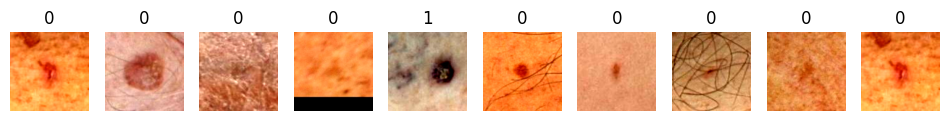

In [ ]:
import random

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    rand_idx = random.randint(0, len(test_loader.dataset) - 1)  # Get a random index
    image, label = test_loader.dataset[rand_idx]
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_title(label)
    axes[i].axis('off')
plt.show()

In [ ]:
# nn.Module is widely used and offeres good flexability, there are others

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # ------ first define the layers

        # first 784 input values, outputs 128 activation values
        self.input = nn.Linear(3*128*128, 128)
        # first hidden layer has 128 input nuerons, and communicates 64 activation values
        self.hidden = nn.Linear(128, 64)
        # output layer takes 64 activations and turns them into 10
        self.output = nn.Linear(64, 2)

    # each nn.Module needs a forward funciton whcih turns input to the network into output... input is x (2-dimensional array size 28x28)
    def forward(self, x):
        # first we flatten 2-d matrix into vector of length 784
        x = x.view(-1, 3*128*128)
        x = F.relu(self.input(x))
        x = F.relu(self.hidden(x))
        # feed the final 10 activations values into softmax to turn them into probabilities
        x = F.log_softmax(self.output(x), dim=1)
        return x

model = NeuralNetwork()

In [ ]:
# our loss function
loss_function = nn.NLLLoss()
# Adam is one of the mplementations of backpropagation
# learning rate sets how quickly model learns
optimizer = optim.Adam(model.parameters(), lr=0.001)

# look over the entire training set 5 times.
epochs = 5
for epoch in range(epochs):
    for images, labels in train_loader:
        # reset the gradients : determine how and which weights are adjusted
        optimizer.zero_grad()

        # use our model to make predictions
        output = model(images)
        # now calculate the loss with our loss function
        loss = loss_function(output, labels)

        # calculate all the gradients for all neurons in our network based on the calculated loss
        loss.backward()
        # we apply this gradient to adjust the weights
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.5977
Epoch [2/5], Loss: 0.6235
Epoch [3/5], Loss: 0.6375
Epoch [4/5], Loss: 0.7519
Epoch [5/5], Loss: 0.6547


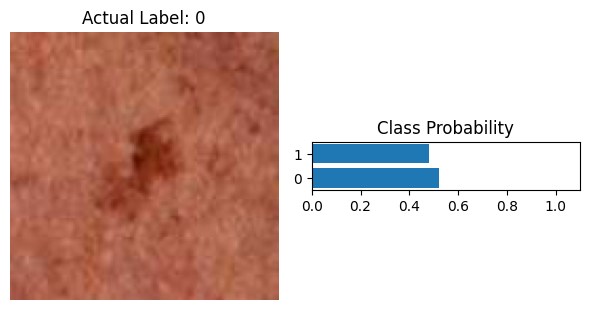

In [ ]:
# @title test images and see probability

def view_classify(image, probabilities, actual_label): # Add actual_class as an argument
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(image.numpy().transpose(1, 2, 0))
    ax1.axis('off')
    ax1.set_title(f"Actual Label: {actual_label}") # Set title with actual class

    ax2.barh(np.arange(2), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    ax2.set_yticklabels(np.arange(2))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

images, labels = next(iter(test_loader))
image = images[0]
label = labels[0]

with torch.no_grad():
    log_probabilities = model(image)

probabilities = torch.exp(log_probabilities)
view_classify(image, probabilities, label)

In [ ]:
# @title create large grid showing all images in testing loader

import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

def create_grid_image(directory, grid_size=(5, 5)):
  """
  Creates a grid image from images in a directory, scaling each image to 50x50.

  Args:
    directory: Path to the directory containing images.
    grid_size: Tuple specifying the number of rows and columns in the grid.

  Returns:
    A single image containing the grid of images.
  """

  image_files = [f for f in os.listdir(directory) if f.endswith(('.jpg', '.png'))]
  images = [Image.open(os.path.join(directory, f)) for f in image_files]

  # Resize images to 50x50
  images = [img.resize((128, 128)) for img in images]

  # Create a new image with the desired grid size
  grid_image = Image.new('RGB', (grid_size[1] * images[0].width, grid_size[0] * images[0].height))

  # Paste images onto the grid
  for i, image in enumerate(images):
    row = i // grid_size[1]
    col = i % grid_size[1]
    grid_image.paste(image, (col * image.width, row * image.height))

  return grid_image

# Example usage
grid_image = create_grid_image('/content/cj-test/target_1')
grid_image.show()  # Display the image
grid_image.save('grid_image.jpg')  # Save the image

In [ ]:
labels

In [ ]:
# epochs = 1
# for epoch in range(epochs):
#     for images, labels in train_loader:
#       print(labels)

In [ ]:
# our loss function
loss_function = nn.NLLLoss()
# Adam is one of the mplementations of backpropagation
# learning rate sets how quickly model learns
optimizer = optim.Adam(model.parameters(), lr=0.001)

# look over the entire training set 5 times.
epochs = 5
for epoch in range(epochs):
    for images, labels in train_loader:
        # reset the gradients : determine how and which weights are adjusted
        optimizer.zero_grad()

        # use our model to make predictions
        output = model(images)
        print(f"Shape of output: {output.shape}")
        print(f"Shape of labels: {labels.shape}")

        # now calculate the loss with our loss function
        loss = loss_function(output, labels)

        # calculate all the gradients for all neurons in our network based on the calculated loss
        loss.backward()
        # we apply this gradient to adjust the weights
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# below is old

In [ ]:
import tensorflow as tf

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [139, 139])
  image /= 255.0  # normalize to [0,1] range
  return image

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 32 * 32, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 32 * 32)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()

# Other

In [ ]:
# @title create custom image from source image

import matplotlib.pyplot as plt

image_path = '/content/train-image/image/ISIC_0015670.jpg'
# label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
# plt.xlabel(caption_image(img_path))
# plt.title(label_names[label].title())
print()

In [ ]:
# create google sheet spreadsheet on show it below in an iframe
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=new_df)